In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Flatten
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

In [2]:
image_types=['real','fake']
data_dir = 'Data1/'
train_dir = os.path.join(data_dir)

train_data = []
for image_id, sp in enumerate(image_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), image_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'ImageID','Image Type'])
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices

IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train_item = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train_item[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train_item / 255.
print('Train Shape: {}'.format(X_Train.shape))

Y_train = train['ImageID'].values
Y_train = to_categorical(Y_train)

1289it [00:02, 616.10it/s]


Train Shape: (1289, 224, 224, 3)


In [3]:

from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [4]:
from tensorflow.keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.models import Model


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

from tensorflow.keras.layers import Activation, Add, Concatenate, GlobalAveragePooling2D,GlobalMaxPooling2D, Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda

from tensorflow.keras.layers import DepthwiseConv2D
import numpy as np
import numpy as np

from tensorflow.python.keras import backend as K

from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export

def get_source_inputs(tensor, layer=None, node_index=None):

  if not hasattr(tensor, '_keras_history'):
    return tensor

  if layer is None or node_index:
    layer, node_index, _ = tensor._keras_history
  if not layer._inbound_nodes:
    return [tensor]
  else:
    node = layer._inbound_nodes[node_index]
    if not node.inbound_layers:
      # Reached an Input layer, stop recursion.
      return nest.flatten(node.input_tensors)
    else:
      source_tensors = []
      for layer, node_index, _, tensor in node.iterate_inbound():
        previous_sources = get_source_inputs(tensor, layer, node_index)
        # Avoid input redundancy.
        for x in previous_sources:
          if x not in source_tensors:
            source_tensors.append(x)
      return source_tensors

def ShuffleNet(include_top=True, input_tensor=None, scale_factor=1.0, pooling='max',weights = None,
               input_shape=(224,224,3), groups=1, load_model=None, num_shuffle_units=[3, 7, 3],
               bottleneck_ratio=0.25, classes=1000):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support ')

    name = "ShuffleNet_%.2gX_g%d_br_%.2g_%s" % (scale_factor, groups, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    out_dim_stage_two = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}
    if groups not in out_dim_stage_two:
        raise ValueError("Invalid number of groups.")

    if pooling not in ['max','avg']:
        raise ValueError("Invalid value for pooling.")

    if not (float(scale_factor) * 4).is_integer():
        raise ValueError("Invalid value for scale_factor. Should be x over 4.")

    exp = np.insert(np.arange(0, len(num_shuffle_units), dtype=np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[groups]  # calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same',
               use_bias=False, strides=(2, 2), activation="relu", name="conv1")(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="maxpool1")(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(0, len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = _block(x, out_channels_in_stage, repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   groups=groups, stage=stage + 2)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name="global_pool")(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name="global_pool")(x)

    if include_top:
        x = Dense(units=classes, name="fc")(x)
        x = Activation('softmax', name='softmax')(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs=inputs, outputs=x, name=name)

    if load_model is not None:
        model.load_weights('', by_name=True)

    return model


def _block(x, channel_map, bottleneck_ratio, repeat=1, groups=1, stage=1):

    x = _shuffle_unit(x, in_channels=channel_map[stage - 2],
                      out_channels=channel_map[stage - 1], strides=2,
                      groups=groups, bottleneck_ratio=bottleneck_ratio,
                      stage=stage, block=1)

    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, in_channels=channel_map[stage - 1],
                          out_channels=channel_map[stage - 1], strides=1,
                          groups=groups, bottleneck_ratio=bottleneck_ratio,
                          stage=stage, block=(i + 1))

    return x


def _shuffle_unit(inputs, in_channels, out_channels, groups, bottleneck_ratio, strides=2, stage=1, block=1):

    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        bn_axis = 1

    prefix = 'stage%d/block%d' % (stage, block)

    #if strides >= 2:
        #out_channels -= in_channels

    # default: 1/4 of the output channel of a ShuffleNet Unit
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    groups = (1 if stage == 2 and block == 1 else groups)

    x = _group_conv(inputs, in_channels, out_channels=bottleneck_channels,
                    groups=(1 if stage == 2 and block == 1 else groups),
                    name='%s/1x1_gconv_1' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_1' % prefix)(x)
    x = Activation('relu', name='%s/relu_gconv_1' % prefix)(x)

    x = Lambda(channel_shuffle, arguments={'groups': groups}, name='%s/channel_shuffle' % prefix)(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", use_bias=False,
                        strides=strides, name='%s/1x1_dwconv_1' % prefix)(x)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_dwconv_1' % prefix)(x)

    x = _group_conv(x, bottleneck_channels, out_channels=out_channels if strides == 1 else out_channels - in_channels,
                    groups=groups, name='%s/1x1_gconv_2' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_2' % prefix)(x)

    if strides < 2:
        ret = Add(name='%s/add' % prefix)([x, inputs])
    else:
        avg = AveragePooling2D(pool_size=3, strides=2, padding='same', name='%s/avg_pool' % prefix)(inputs)
        ret = Concatenate(bn_axis, name='%s/concat' % prefix)([x, avg])

    ret = Activation('relu', name='%s/relu_out' % prefix)(ret)

    return ret


def _group_conv(x, in_channels, out_channels, groups, kernel=1, stride=1, name=''):

    if groups == 1:
        return Conv2D(filters=out_channels, kernel_size=kernel, padding='same',
                      use_bias=False, strides=stride, name=name)(x)

    # number of intput channels per group
    ig = in_channels // groups
    group_list = []

    assert out_channels % groups == 0

    for i in range(groups):
        offset = i * ig
        group = Lambda(lambda z: z[:, :, :, offset: offset + ig], name='%s/g%d_slice' % (name, i))(x)
        group_list.append(Conv2D(int(0.5 + out_channels / groups), kernel_size=kernel, strides=stride,
                                 use_bias=False, padding='same', name='%s_/g%d' % (name, i))(group))
    return Concatenate(name='%s/concat' % name)(group_list)


def channel_shuffle(x, groups):

    height, width, in_channels = x.shape.as_list()[1:]
    channels_per_group = in_channels // groups

    x = K.reshape(x, [-1, height, width, groups, channels_per_group])
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))  # transpose
    x = K.reshape(x, [-1, height, width, in_channels])

    return x

In [5]:
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# base modelleri oluşturuyoruz
base_model1 = SqueezeNet(input_shape=(224, 224, 3))
base_model2 = ShuffleNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=2)

# layerları eğitilebilir olarak ayarlıyoruz
for layer in base_model1.layers:
    layer.trainable = True
for layer in base_model2.layers:
    layer.trainable = True

# iki modelde aynı isimli layer lar var hata veriyordu böylece layer isimlerini değiştirip çözdük
for layer in base_model1.layers:
    layer._name = 'squeezenet_' + layer.name
for layer in base_model2.layers:
    layer._name = 'shufflenet_' + layer.name

In [6]:
# 2 modelin çıktısını birleştirme
concatenated_output = Concatenate()([base_model1.output, base_model2.output])

# özellik haritalarını düzleştirir
flatten_layer = Flatten()(concatenated_output)

# overfittingi engellemek için kullanılır ağın genelleme yeteneğini arttırır
dropout_layer = Dropout(0.8)(flatten_layer)

#tam bağlı bir katman oluşturur
output_layer = Dense(2, activation='softmax')(dropout_layer)

# modelimizin girişlerini ve çıkışlarını ayarlıyoruz
model = Model(inputs=[base_model1.input, base_model2.input], outputs=output_layer)
import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #lr=0.001 , 0.1 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.3, random_state=SEED)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
shufflenet_input_2 (InputLayer) [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
shufflenet_conv1 (Conv2D)       (None, 112, 112, 24) 648         shufflenet_input_2[0][0]         
__________________________________________________________________________________________________
shufflenet_maxpool1 (MaxPooling (None, 56, 56, 24)   0           shufflenet_conv1[0][0]           
__________________________________________________________________________________________________
shufflenet_stage2/block1/1x1_gc (None, 56, 56, 36)   864         shufflenet_maxpool1[0][0]        
_______________________________________________________________________________________

In [7]:
EPOCHS = 50#50
BATCH_SIZE= 32 #64

hist_concat = model.fit([X_train,X_train], Y_train,
                        batch_size = BATCH_SIZE,
                shuffle=True, #burada her epoch öncesinde bir karıştırma yaparak overfitting in önüne geçmeye çalışıyoruz
               epochs=EPOCHS,
               verbose=1,
               validation_data=([X_val, X_val], Y_val))

Epoch 1/50
29/29 [==============================] - 20s 681ms/step - loss: 4.1143 - accuracy: 0.5909 - val_loss: 0.6793 - val_accuracy: 0.5814
Epoch 2/50
29/29 [==============================] - 19s 657ms/step - loss: 3.2171 - accuracy: 0.6353 - val_loss: 0.6788 - val_accuracy: 0.5814
Epoch 3/50
29/29 [==============================] - 24s 831ms/step - loss: 2.4087 - accuracy: 0.7095 - val_loss: 0.6880 - val_accuracy: 0.5814
Epoch 4/50
29/29 [==============================] - 19s 654ms/step - loss: 1.7363 - accuracy: 0.7450 - val_loss: 0.6922 - val_accuracy: 0.5814
Epoch 5/50
29/29 [==============================] - 19s 656ms/step - loss: 1.1757 - accuracy: 0.8204 - val_loss: 0.7264 - val_accuracy: 0.5814
Epoch 6/50
29/29 [==============================] - 19s 662ms/step - loss: 0.6844 - accuracy: 0.8858 - val_loss: 0.7495 - val_accuracy: 0.5814
Epoch 7/50
29/29 [==============================] - 24s 822ms/step - loss: 0.5363 - accuracy: 0.9069 - val_loss: 0.8428 - val_accuracy: 0.5814

 MODEL SONUÇLARI
Doğruluk:  0.9948320413436692
F1_Skor:  0.9947003724802805
Hassasiyet:  0.9939024390243902
Duyarlılık:  0.9955555555555555


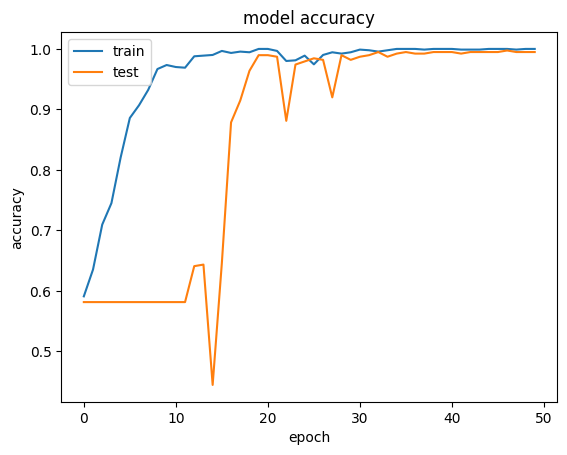

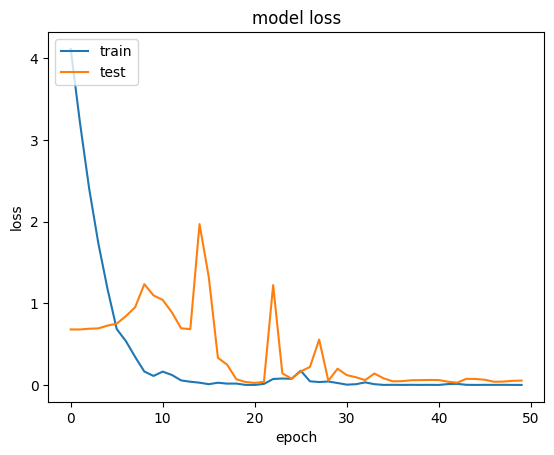

Confusion Matrix Squezenet+Shuffle
[[162   0]
 [  2 223]]


<AxesSubplot:>

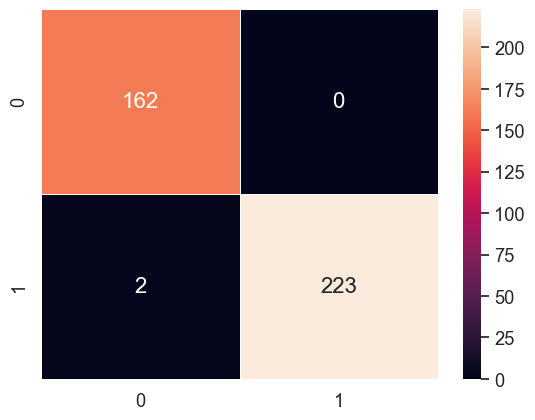

In [8]:
y_pred = model.predict([X_val, X_val])
y_pred=np.argmax(y_pred , axis =1).reshape(-1,1)
Y_val=np.argmax(Y_val, axis =1).reshape(-1,1)

print(" MODEL SONUÇLARI")
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred, average='macro'))
print("Hassasiyet: ",precision_score(Y_val, y_pred, average='macro'))
print("Duyarlılık: ", recall_score(Y_val, y_pred, average='macro'))


plt.plot(hist_concat.history['accuracy'])
plt.plot(hist_concat.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist_concat.history['loss'])
plt.plot(hist_concat.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix Squezenet+Shuffle')
cm_dense = confusion_matrix(Y_val, y_pred)
print(cm_dense)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm_dense, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size

In [9]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Flatten
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.util import nest

# Define image types
image_types = ['real', 'fake']
data_dir = 'Data1/'
train_dir = os.path.join(data_dir)

# Read and preprocess data
train_data = []
for image_id, sp in enumerate(image_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), image_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'ImageID', 'Image Type'])
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))

IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train_item = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train_item[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train_item / 255.
Y_train = train['ImageID'].values
Y_train = to_categorical(Y_train)

0it [00:00, ?it/s]

1289it [00:01, 750.75it/s]


In [10]:

from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [11]:
from tensorflow.keras import backend as K
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.keras.models import Model


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

from tensorflow.keras.layers import Activation, Add, Concatenate, GlobalAveragePooling2D,GlobalMaxPooling2D, Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda

from tensorflow.keras.layers import DepthwiseConv2D
import numpy as np
import numpy as np

from tensorflow.python.keras import backend as K

from tensorflow.python.util import nest
from tensorflow.python.util.tf_export import keras_export

def get_source_inputs(tensor, layer=None, node_index=None):

  if not hasattr(tensor, '_keras_history'):
    return tensor

  if layer is None or node_index:
    layer, node_index, _ = tensor._keras_history
  if not layer._inbound_nodes:
    return [tensor]
  else:
    node = layer._inbound_nodes[node_index]
    if not node.inbound_layers:
      # Reached an Input layer, stop recursion.
      return nest.flatten(node.input_tensors)
    else:
      source_tensors = []
      for layer, node_index, _, tensor in node.iterate_inbound():
        previous_sources = get_source_inputs(tensor, layer, node_index)
        # Avoid input redundancy.
        for x in previous_sources:
          if x not in source_tensors:
            source_tensors.append(x)
      return source_tensors

def ShuffleNet(include_top=True, input_tensor=None, scale_factor=1.0, pooling='max',weights = None,
               input_shape=(224,224,3), groups=1, load_model=None, num_shuffle_units=[3, 7, 3],
               bottleneck_ratio=0.25, classes=1000):

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support ')

    name = "ShuffleNet_%.2gX_g%d_br_%.2g_%s" % (scale_factor, groups, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)


    out_dim_stage_two = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}
    if groups not in out_dim_stage_two:
        raise ValueError("Invalid number of groups.")

    if pooling not in ['max','avg']:
        raise ValueError("Invalid value for pooling.")

    if not (float(scale_factor) * 4).is_integer():
        raise ValueError("Invalid value for scale_factor. Should be x over 4.")

    exp = np.insert(np.arange(0, len(num_shuffle_units), dtype=np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[groups]  # calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same',
               use_bias=False, strides=(2, 2), activation="relu", name="conv1")(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="maxpool1")(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(0, len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = _block(x, out_channels_in_stage, repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   groups=groups, stage=stage + 2)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name="global_pool")(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name="global_pool")(x)

    if include_top:
        x = Dense(units=classes, name="fc")(x)
        x = Activation('softmax', name='softmax')(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs=inputs, outputs=x, name=name)

    if load_model is not None:
        model.load_weights('', by_name=True)

    return model


def _block(x, channel_map, bottleneck_ratio, repeat=1, groups=1, stage=1):

    x = _shuffle_unit(x, in_channels=channel_map[stage - 2],
                      out_channels=channel_map[stage - 1], strides=2,
                      groups=groups, bottleneck_ratio=bottleneck_ratio,
                      stage=stage, block=1)

    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, in_channels=channel_map[stage - 1],
                          out_channels=channel_map[stage - 1], strides=1,
                          groups=groups, bottleneck_ratio=bottleneck_ratio,
                          stage=stage, block=(i + 1))

    return x


def _shuffle_unit(inputs, in_channels, out_channels, groups, bottleneck_ratio, strides=2, stage=1, block=1):

    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        bn_axis = 1

    prefix = 'stage%d/block%d' % (stage, block)

    #if strides >= 2:
        #out_channels -= in_channels

    # default: 1/4 of the output channel of a ShuffleNet Unit
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    groups = (1 if stage == 2 and block == 1 else groups)

    x = _group_conv(inputs, in_channels, out_channels=bottleneck_channels,
                    groups=(1 if stage == 2 and block == 1 else groups),
                    name='%s/1x1_gconv_1' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_1' % prefix)(x)
    x = Activation('relu', name='%s/relu_gconv_1' % prefix)(x)

    x = Lambda(channel_shuffle, arguments={'groups': groups}, name='%s/channel_shuffle' % prefix)(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", use_bias=False,
                        strides=strides, name='%s/1x1_dwconv_1' % prefix)(x)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_dwconv_1' % prefix)(x)

    x = _group_conv(x, bottleneck_channels, out_channels=out_channels if strides == 1 else out_channels - in_channels,
                    groups=groups, name='%s/1x1_gconv_2' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_2' % prefix)(x)

    if strides < 2:
        ret = Add(name='%s/add' % prefix)([x, inputs])
    else:
        avg = AveragePooling2D(pool_size=3, strides=2, padding='same', name='%s/avg_pool' % prefix)(inputs)
        ret = Concatenate(bn_axis, name='%s/concat' % prefix)([x, avg])

    ret = Activation('relu', name='%s/relu_out' % prefix)(ret)

    return ret


def _group_conv(x, in_channels, out_channels, groups, kernel=1, stride=1, name=''):

    if groups == 1:
        return Conv2D(filters=out_channels, kernel_size=kernel, padding='same',
                      use_bias=False, strides=stride, name=name)(x)

    # number of intput channels per group
    ig = in_channels // groups
    group_list = []

    assert out_channels % groups == 0

    for i in range(groups):
        offset = i * ig
        group = Lambda(lambda z: z[:, :, :, offset: offset + ig], name='%s/g%d_slice' % (name, i))(x)
        group_list.append(Conv2D(int(0.5 + out_channels / groups), kernel_size=kernel, strides=stride,
                                 use_bias=False, padding='same', name='%s_/g%d' % (name, i))(group))
    return Concatenate(name='%s/concat' % name)(group_list)


def channel_shuffle(x, groups):

    height, width, in_channels = x.shape.as_list()[1:]
    channels_per_group = in_channels // groups

    x = K.reshape(x, [-1, height, width, groups, channels_per_group])
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))  # transpose
    x = K.reshape(x, [-1, height, width, in_channels])

    return x

In [12]:
# Create base models
base_model1 = SqueezeNet(input_shape=(224, 224, 3))
base_model2 = ShuffleNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=2)

# Make layers trainable
for layer in base_model1.layers:
    layer.trainable = True
for layer in base_model2.layers:
    layer.trainable = True

# Rename layers to avoid conflicts
for layer in base_model1.layers:
    layer._name = 'squeezenet_' + layer.name
for layer in base_model2.layers:
    layer._name = 'shufflenet_' + layer.name

# Merge outputs of base models
concatenated_output = tf.keras.layers.Concatenate()([base_model1.output, base_model2.output])

# Flatten and add dropout
flatten_layer = Flatten()(concatenated_output)
dropout_layer = Dropout(0.8)(flatten_layer)

# Add output layer
output_layer = Dense(2, activation='softmax')(dropout_layer)

# Create model
model = Model(inputs=[base_model1.input, base_model2.input], outputs=output_layer)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.3, random_state=SEED)

# Define ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


# Train model with ReduceLROnPlateau callback
EPOCHS = 35
BATCH_SIZE = 32
hist_concat = model.fit([X_train,X_train], Y_train,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=([X_val, X_val], Y_val),
                        callbacks=[reduce_lr])



Epoch 1/35
29/29 [==============================] - 19s 662ms/step - loss: 4.9357 - accuracy: 0.5299 - val_loss: 0.6790 - val_accuracy: 0.5814
Epoch 2/35
29/29 [==============================] - 19s 641ms/step - loss: 3.6596 - accuracy: 0.6286 - val_loss: 0.6843 - val_accuracy: 0.5814
Epoch 3/35
29/29 [==============================] - 19s 643ms/step - loss: 2.2468 - accuracy: 0.7328 - val_loss: 0.6978 - val_accuracy: 0.4186
Epoch 4/35
29/29 [==============================] - 19s 642ms/step - loss: 1.1113 - accuracy: 0.8570 - val_loss: 0.6806 - val_accuracy: 0.5814
Epoch 5/35
29/29 [==============================] - 19s 640ms/step - loss: 0.4748 - accuracy: 0.9191 - val_loss: 0.6798 - val_accuracy: 0.5814
Epoch 6/35
29/29 [==============================] - 19s 643ms/step - loss: 0.2768 - accuracy: 0.9479 - val_loss: 0.6771 - val_accuracy: 0.5814
Epoch 7/35
29/29 [==============================] - 19s 643ms/step - loss: 0.2268 - accuracy: 0.9656 - val_loss: 0.7727 - val_accuracy: 0.4186

MODEL RESULTS
Accuracy:  0.9870801033591732
F1 Score:  0.9867832382773812
Precision:  0.9850299401197604
Recall:  0.9888888888888889


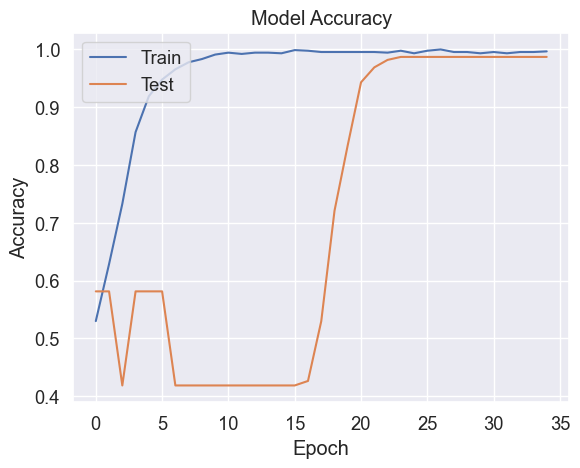

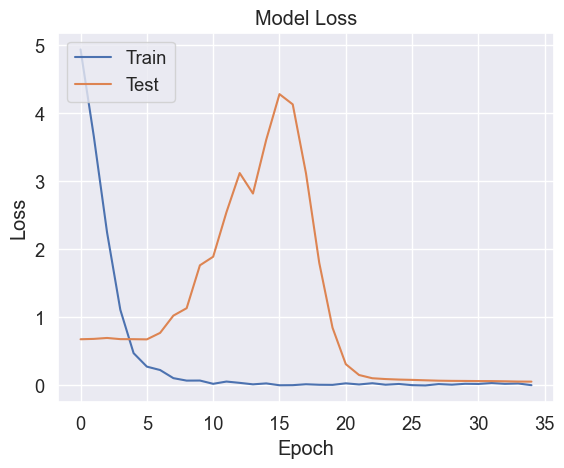

Confusion Matrix SqueezeNet+Shuffle
[[162   0]
 [  5 220]]


<AxesSubplot:>

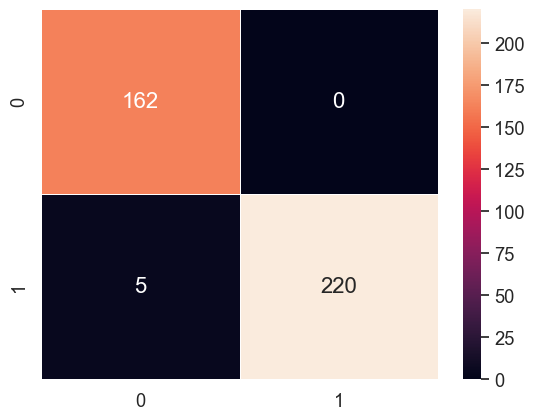

In [13]:
# Predict validation set
y_pred = model.predict([X_val, X_val])
y_pred=np.argmax(y_pred , axis =1).reshape(-1,1)
Y_val=np.argmax(Y_val, axis =1).reshape(-1,1)

# Print evaluation metrics
print("MODEL RESULTS")
print("Accuracy: ", accuracy_score(Y_val, y_pred))
print("F1 Score: ", f1_score(Y_val, y_pred, average='macro'))
print("Precision: ", precision_score(Y_val, y_pred, average='macro'))
print("Recall: ", recall_score(Y_val, y_pred, average='macro'))

# Plot training history
plt.plot(hist_concat.history['accuracy'])
plt.plot(hist_concat.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist_concat.history['loss'])
plt.plot(hist_concat.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot confusion matrix
print('Confusion Matrix SqueezeNet+Shuffle')
cm_dense = confusion_matrix(Y_val, y_pred)
print(cm_dense)
sn.set(font_scale=1.2)
sn.heatmap(cm_dense, annot=True, fmt="d", linewidths=.5, annot_kws={"size": 16})